# Hybrid CNN-LSTM - ArXiv Classification

CNN 1D (abstracts) + Bidirectional LSTM (titles) + Attention mechanisms

In [ ]:
!pip install -q torch scikit-learn pandas matplotlib seaborn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Upload Required Files

Upload these files to Colab:
1. arxiv_papers_raw.csv
2. glove.6B.300d.txt

In [ ]:
import os

required_files = ['arxiv_papers_raw.csv', 'glove.6B.300d.txt']
missing = [f for f in required_files if not os.path.exists(f)]

if missing:
    print(f"Upload required files: {', '.join(missing)}")
else:
    print("All required files found")

## Model Architecture

Focal Loss for hard-to-classify examples

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output, mask=None):
        scores = self.attention(lstm_output).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return context, attention_weights


class WeightedAttentionFusion(nn.Module):
    def __init__(self, title_dim, abstract_dim):
        super().__init__()
        self.title_weight = nn.Linear(title_dim, 1)
        self.abstract_weight = nn.Linear(abstract_dim, 1)

    def forward(self, title_repr, abstract_repr):
        w_title = self.title_weight(title_repr)
        w_abstract = self.abstract_weight(abstract_repr)
        weights = torch.cat([w_title, w_abstract], dim=1)
        fusion_weights = F.softmax(weights, dim=1)
        weighted_title = title_repr * fusion_weights[:, 0:1]
        weighted_abstract = abstract_repr * fusion_weights[:, 1:2]
        fused = torch.cat([weighted_title, weighted_abstract], dim=1)
        return fused, fusion_weights


class HybridCNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, num_filters=128, kernel_sizes=[3,4,5],
                 lstm_hidden=128, num_classes=4, dropout=0.6, pretrained_embeddings=None):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True
        
        self.embed_dropout = nn.Dropout(dropout * 0.4)

        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.conv_bn = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        self.conv_dropout = nn.Dropout(dropout * 0.3)
        total_filters = num_filters * len(kernel_sizes)

        self.lstm = nn.LSTM(embed_dim, lstm_hidden, num_layers=2, batch_first=True, 
                           bidirectional=True, dropout=dropout if dropout > 0 else 0)
        self.lstm_attention = SelfAttention(lstm_hidden * 2)

        self.fusion = WeightedAttentionFusion(lstm_hidden * 2, total_filters)

        fused_dim = lstm_hidden * 2 + total_filters
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(fused_dim),
            nn.Dropout(dropout),
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout * 0.8),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, title_ids, abstract_ids, title_mask=None):
        title_embed = self.embed_dropout(self.embedding(title_ids))
        lstm_out, _ = self.lstm(title_embed)
        title_repr, title_attn = self.lstm_attention(lstm_out, title_mask)

        abstract_embed = self.embed_dropout(self.embedding(abstract_ids)).transpose(1, 2)
        pooled_outputs = []
        for conv, bn in zip(self.convs, self.conv_bn):
            x = F.relu(bn(conv(abstract_embed)))
            x = self.conv_dropout(x)
            x_pool = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
            pooled_outputs.append(x_pool)
        abstract_repr = torch.cat(pooled_outputs, dim=1)

        fused_repr, fusion_weights = self.fusion(title_repr, abstract_repr)
        logits = self.classifier(fused_repr)

        attention_maps = {
            'title_attention': title_attn,
            'abstract_attention': None,
            'fusion_weights': fusion_weights
        }
        return logits, attention_maps

## Preprocessing

In [ ]:
class Vocabulary:
    def __init__(self, max_vocab_size=50000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()

    def build_vocab(self, texts):
        for text in texts:
            words = self.tokenize(text)
            self.word_counts.update(words)
        filtered_words = [word for word, count in self.word_counts.most_common() if count >= self.min_freq][:self.max_vocab_size - 2]
        for idx, word in enumerate(filtered_words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
        return [w.strip() for w in text.split() if w.strip()]

    def encode(self, text, max_len=None):
        words = self.tokenize(text)
        if max_len:
            words = words[:max_len]
        return [self.word2idx.get(word, 1) for word in words]

    def __len__(self):
        return len(self.word2idx)


def load_glove_embeddings(vocab, embed_dim=300, glove_path='glove.6B.300d.txt'):
    print("Loading GloVe embeddings...")
    embeddings = np.random.randn(len(vocab), embed_dim) * 0.01
    embeddings[0] = np.zeros(embed_dim)
    
    found = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='GloVe'):
            parts = line.strip().split()
            word = parts[0]
            if word in vocab.word2idx:
                idx = vocab.word2idx[word]
                embeddings[idx] = np.array([float(x) for x in parts[1:]])
                found += 1
    
    print(f"Loaded {found}/{len(vocab)} embeddings ({found/len(vocab)*100:.1f}%)")
    return torch.FloatTensor(embeddings)


class HybridDataset(Dataset):
    def __init__(self, titles, abstracts, labels, vocab, max_title_len=30, max_abstract_len=250):
        self.titles = titles
        self.abstracts = abstracts
        self.labels = labels
        self.vocab = vocab
        self.max_title_len = max_title_len
        self.max_abstract_len = max_abstract_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title_ids = self.vocab.encode(self.titles[idx], self.max_title_len)
        title_len = len(title_ids)
        title_ids += [0] * (self.max_title_len - title_len)

        abstract_ids = self.vocab.encode(self.abstracts[idx], self.max_abstract_len)
        abstract_len = len(abstract_ids)
        abstract_ids += [0] * (self.max_abstract_len - abstract_len)

        title_mask = [1] * title_len + [0] * (self.max_title_len - title_len)

        return {
            'title_ids': torch.tensor(title_ids, dtype=torch.long),
            'abstract_ids': torch.tensor(abstract_ids, dtype=torch.long),
            'title_mask': torch.tensor(title_mask, dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Data Preparation

In [ ]:
df = pd.read_csv('arxiv_papers_raw.csv')
print(f"Samples: {len(df)}")
print(df['category'].value_counts())

le = LabelEncoder()
labels = le.fit_transform(df['category'])

vocab = Vocabulary(max_vocab_size=50000, min_freq=2)
all_texts = df['title'].tolist() + df['abstract'].tolist()
vocab.build_vocab(all_texts)
print(f"Vocab size: {len(vocab)}")

pretrained_embeddings = load_glove_embeddings(vocab, embed_dim=300)

X_temp, X_test, y_temp, y_test = train_test_split(
    df[['title', 'abstract']].values, labels, test_size=0.15, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(1-0.15), random_state=42, stratify=y_temp
)

train_ds = HybridDataset(X_train[:,0], X_train[:,1], y_train, vocab, max_abstract_len=250)
val_ds = HybridDataset(X_val[:,0], X_val[:,1], y_val, vocab, max_abstract_len=250)
test_ds = HybridDataset(X_test[:,0], X_test[:,1], y_test, vocab, max_abstract_len=250)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

## Training Setup

V4 - Focal Loss para cs.AI:
- Focal Loss con gamma=2.0 (enfoca en ejemplos dificiles)
- Class weights: [3.0, 1.0, 0.8, 1.2] (cs.AI boost agresivo)
- Modelo compacto: 128 filters, 128 hidden (~4M params)
- LR: 0.001, Patience: 4
- Dropout: 0.6, AdamW weight decay 5e-4
- GloVe embeddings pre-entrenados
- Max abstract: 250 tokens

Formula Focal Loss: FL(pt) = -alpha * (1-pt)^gamma * log(pt)
- pt: probabilidad de clase correcta
- gamma=2: penaliza mas errores en ejemplos dificiles
- alpha: class weights para balance

In [ ]:
BATCH_SIZE = 64
EPOCHS = 25
LR = 0.001
DROPOUT = 0.6
CLASS_WEIGHTS = [3.0, 1.0, 0.8, 1.2]
FOCAL_GAMMA = 2.0
PATIENCE = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = HybridCNNLSTM(
    vocab_size=len(vocab),
    embed_dim=300,
    num_filters=128,
    kernel_sizes=[3,4,5],
    lstm_hidden=128,
    num_classes=4,
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_embeddings
).to(device)

print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

class_weights = torch.FloatTensor(CLASS_WEIGHTS).to(device)
criterion = FocalLoss(alpha=class_weights, gamma=FOCAL_GAMMA)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4)

## Training

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    for batch in tqdm(loader, desc='Train'):
        title_ids = batch['title_ids'].to(device)
        abstract_ids = batch['abstract_ids'].to(device)
        title_mask = batch['title_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _ = model(title_ids, abstract_ids, title_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), accuracy_score(all_labels, all_preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Val'):
            title_ids = batch['title_ids'].to(device)
            abstract_ids = batch['abstract_ids'].to(device)
            title_mask = batch['title_mask'].to(device)
            labels = batch['label'].to(device)

            logits, _ = model(title_ids, abstract_ids, title_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1, all_preds, all_labels

In [9]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_acc = 0
best_model_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | F1: {val_f1:.4f} | Gap: {abs(train_acc-val_acc):.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"Best: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stop")
            break

model.load_state_dict(best_model_state)
print(f"\nBest val: {best_val_acc:.4f}")


Epoch 1/20


Val: 100%|██████████| 29/29 [00:00<00:00, 48.96it/s]


Train: 0.2981 | Val: 0.3665 | F1: 0.3441 | Gap: 0.0683
Best: 0.3665

Epoch 2/20


Val: 100%|██████████| 29/29 [00:00<00:00, 54.06it/s]


Train: 0.3609 | Val: 0.3165 | F1: 0.2401 | Gap: 0.0444

Epoch 3/20


Val: 100%|██████████| 29/29 [00:00<00:00, 54.66it/s]


Train: 0.4158 | Val: 0.4281 | F1: 0.3708 | Gap: 0.0123
Best: 0.4281

Epoch 4/20


Val: 100%|██████████| 29/29 [00:00<00:00, 55.27it/s]


Train: 0.4678 | Val: 0.4137 | F1: 0.3697 | Gap: 0.0541

Epoch 5/20


Val: 100%|██████████| 29/29 [00:00<00:00, 40.91it/s]


Train: 0.4982 | Val: 0.3853 | F1: 0.3408 | Gap: 0.1128

Epoch 6/20


Val: 100%|██████████| 29/29 [00:00<00:00, 54.45it/s]


Train: 0.5333 | Val: 0.4559 | F1: 0.4620 | Gap: 0.0774
Best: 0.4559

Epoch 7/20


Val: 100%|██████████| 29/29 [00:00<00:00, 52.87it/s]


Train: 0.5586 | Val: 0.4414 | F1: 0.4433 | Gap: 0.1172

Epoch 8/20


Val: 100%|██████████| 29/29 [00:00<00:00, 42.20it/s]


Train: 0.5758 | Val: 0.4642 | F1: 0.4698 | Gap: 0.1116
Best: 0.4642

Epoch 9/20


Val: 100%|██████████| 29/29 [00:00<00:00, 40.22it/s]


Train: 0.6078 | Val: 0.4253 | F1: 0.4350 | Gap: 0.1825

Epoch 10/20


Val: 100%|██████████| 29/29 [00:00<00:00, 53.67it/s]


Train: 0.6133 | Val: 0.4659 | F1: 0.4757 | Gap: 0.1474
Best: 0.4659

Epoch 11/20


Val: 100%|██████████| 29/29 [00:00<00:00, 45.73it/s]


Train: 0.6320 | Val: 0.3865 | F1: 0.3901 | Gap: 0.2455

Epoch 12/20


Val: 100%|██████████| 29/29 [00:00<00:00, 52.46it/s]


Train: 0.6403 | Val: 0.4531 | F1: 0.4514 | Gap: 0.1872

Epoch 13/20


Val: 100%|██████████| 29/29 [00:00<00:00, 52.03it/s]


Train: 0.6513 | Val: 0.4381 | F1: 0.4462 | Gap: 0.2132

Epoch 14/20


Val: 100%|██████████| 29/29 [00:00<00:00, 44.96it/s]


Train: 0.6717 | Val: 0.4492 | F1: 0.4366 | Gap: 0.2226

Epoch 15/20


Val: 100%|██████████| 29/29 [00:00<00:00, 52.34it/s]

Train: 0.7196 | Val: 0.4092 | F1: 0.4119 | Gap: 0.3104
Early stop

Best val: 0.4659


## Test Evaluation

In [ ]:
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print(f"Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1: {test_f1:.4f}")
print(f"\n{classification_report(test_labels, test_preds, target_names=le.classes_, digits=4)}")

report_dict = classification_report(test_labels, test_preds, target_names=le.classes_, output_dict=True)
if 'cs.AI' in report_dict:
    cs_ai_recall = report_dict['cs.AI']['recall']
    print(f"\ncs.AI recall: {cs_ai_recall:.4f} ({cs_ai_recall*100:.2f}%)")

## Dataset Analysis - Why cs.AI Fails

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, 
            yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, 
            yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("cs.AI confusion breakdown:")
cs_ai_idx = list(le.classes_).index('cs.AI')
cs_ai_row = cm[cs_ai_idx]
for i, count in enumerate(cs_ai_row):
    pct = (count / cs_ai_row.sum()) * 100
    print(f"  Predicted as {le.classes_[i]}: {count} ({pct:.1f}%)")

In [ ]:
def get_distinctive_words(df, class_name, vocab, other_classes, top_n=20):
    class_words = Counter()
    other_words = Counter()
    
    class_docs = df[df['category'] == class_name]
    for text in class_docs['title'].tolist() + class_docs['abstract'].tolist():
        class_words.update(vocab.tokenize(text))
    
    other_docs = df[df['category'].isin(other_classes)]
    for text in other_docs['title'].tolist() + other_docs['abstract'].tolist():
        other_words.update(vocab.tokenize(text))
    
    class_total = sum(class_words.values())
    other_total = sum(other_words.values())
    
    distinctiveness = {}
    for word in class_words:
        class_freq = class_words[word] / class_total
        other_freq = other_words.get(word, 0) / other_total if other_total > 0 else 0
        if other_freq > 0:
            distinctiveness[word] = class_freq / other_freq
    
    sorted_words = sorted(distinctiveness.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

print("Most distinctive words (relative to other classes):\n")
for cls in le.classes_:
    other = [c for c in le.classes_ if c != cls]
    distinctive = get_distinctive_words(df, cls, vocab, other, top_n=15)
    print(f"{cls}:")
    words = [f"{word}({ratio:.2f}x)" for word, ratio in distinctive]
    print(f"  {', '.join(words)}")
    print()

In [ ]:
cs_ai_idx = list(le.classes_).index('cs.AI')
X_test_data = df[['title', 'abstract']].iloc[-len(y_test):]

cs_ai_misclassified_indices = [i for i in range(len(y_test)) if test_labels[i] == cs_ai_idx and test_preds[i] != cs_ai_idx]

print(f"cs.AI papers misclassified: {len(cs_ai_misclassified_indices)}/{sum(test_labels == cs_ai_idx)}\n")
print("Sample of 10 misclassified cs.AI papers (from original dataset):\n")

for i, idx in enumerate(cs_ai_misclassified_indices[:10]):
    true_class = le.classes_[test_labels[idx]]
    pred_class = le.classes_[test_preds[idx]]
    
    row = X_test_data.iloc[idx]
    title = row['title'][:100]
    abstract = row['abstract'][:150]
    
    print(f"{i+1}. True: {true_class} -> Predicted: {pred_class}")
    print(f"   Title: {title}...")
    print(f"   Abstract: {abstract}...")
    print()

In [ ]:
test_df = df.iloc[X_test.index] if hasattr(X_test, 'index') else df.tail(len(y_test))
test_indices = list(range(len(y_test)))

cs_ai_label = list(le.classes_).index('cs.AI')
cs_ai_misclassified = [i for i in test_indices if test_labels[i] == cs_ai_label and test_preds[i] != cs_ai_label]

print(f"cs.AI misclassified examples: {len(cs_ai_misclassified)}/{sum(test_labels == cs_ai_label)}\n")
print("Sample of 10 misclassified cs.AI papers:\n")

for idx in cs_ai_misclassified[:10]:
    actual_idx = test_indices[idx]
    true_class = le.classes_[test_labels[idx]]
    pred_class = le.classes_[test_preds[idx]]
    
    sample = test_ds[idx]
    title_tokens = sample['title_ids'].numpy()
    title_words = [vocab.idx2word.get(t, '') for t in title_tokens if t != 0]
    title = ' '.join(title_words[:15])
    
    print(f"{idx}. True: {true_class} | Pred: {pred_class}")
    print(f"   Title: {title}...")
    print()

In [ ]:
from collections import Counter

def get_class_vocabulary(df, class_name, vocab, top_n=30):
    class_docs = df[df['category'] == class_name]
    all_words = []
    for text in class_docs['title'].tolist() + class_docs['abstract'].tolist():
        all_words.extend(vocab.tokenize(text))
    return Counter(all_words).most_common(top_n)

print("Top distinctive words per class:\n")
for cls in le.classes_:
    print(f"{cls}:")
    top_words = get_class_vocabulary(df, cls, vocab, top_n=20)
    words = [f"{word}({count})" for word, count in top_words[:20]]
    print(f"  {', '.join(words)}")
    print()

## Training History

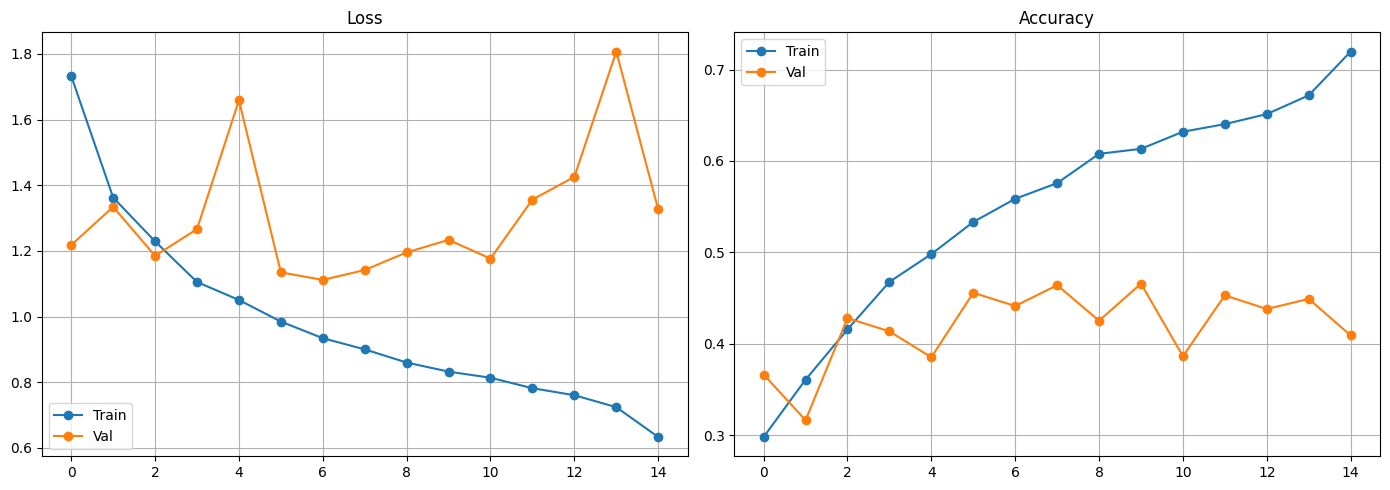

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Val', marker='o')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Val', marker='o')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('history.png', dpi=150, bbox_inches='tight')
plt.show()

## Attention Visualization

Prediction: cs.CL
True label: cs.CL
Fusion - Title: 0.979, Abstract: 0.021
Probabilities: {'cs.AI': np.float32(0.097), 'cs.CL': np.float32(0.858), 'cs.CV': np.float32(0.0), 'cs.LG': np.float32(0.045)}


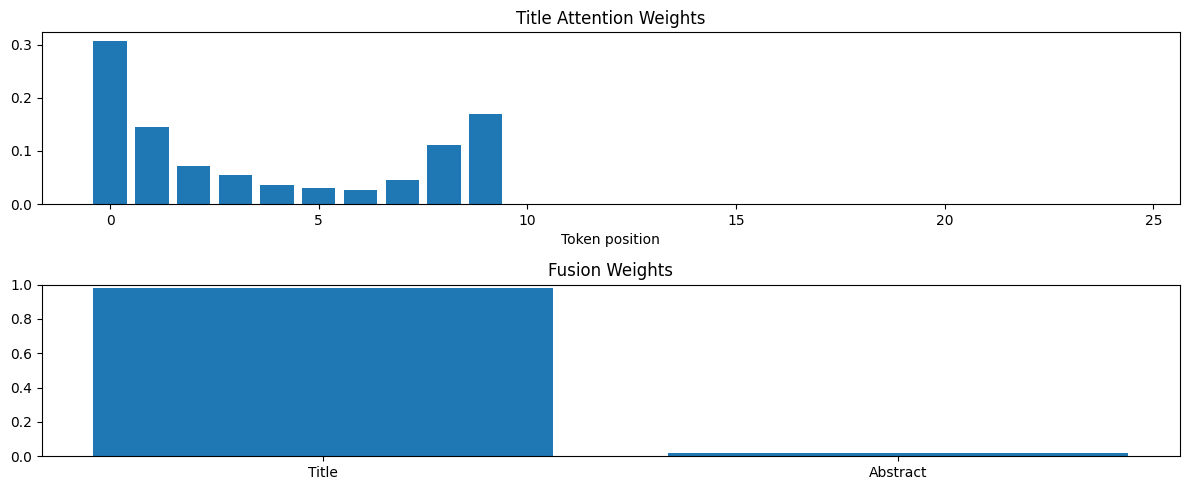

In [13]:
model.eval()
sample = test_ds[0]
title_ids = sample['title_ids'].unsqueeze(0).to(device)
abstract_ids = sample['abstract_ids'].unsqueeze(0).to(device)
title_mask = sample['title_mask'].unsqueeze(0).to(device)

with torch.no_grad():
    logits, attn_maps = model(title_ids, abstract_ids, title_mask)
    pred = torch.argmax(logits, dim=1).item()
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

title_attn = attn_maps['title_attention'].cpu().numpy()[0]
fusion_weights = attn_maps['fusion_weights'].cpu().numpy()[0]

print(f"Prediction: {le.classes_[pred]}")
print(f"True label: {le.classes_[sample['label']]}")
print(f"Fusion - Title: {fusion_weights[0]:.3f}, Abstract: {fusion_weights[1]:.3f}")
print(f"Probabilities: {dict(zip(le.classes_, probs.round(3)))}")

fig, axes = plt.subplots(2, 1, figsize=(12, 5))
axes[0].bar(range(len(title_attn[:25])), title_attn[:25])
axes[0].set_title('Title Attention Weights')
axes[0].set_xlabel('Token position')
axes[1].bar(['Title', 'Abstract'], fusion_weights)
axes[1].set_title('Fusion Weights')
axes[1].set_ylim([0, 1])
plt.tight_layout()
plt.savefig('attention.png', dpi=150, bbox_inches='tight')
plt.show()